In [8]:
import pymc3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use("light_mode")

## Load in Data

In [2]:
df = pd.read_csv("location_data_hw8_2022.csv")

df.head()

,t,red_pos_X,red_pos_Y,blue_pos_X,blue_pos_Y
0,1.718397,1.330174,0.993564,1.081700,-1.295918
1,2.998056,1.310404,1.012772,1.004997,-1.254394
2,6.015073,1.270312,1.028386,1.113696,-1.321257
3,8.267651,1.331131,0.948223,1.001845,-1.285209
4,9.279321,1.346159,0.963485,1.113008,-1.261147


In [3]:
time = df['t'].to_numpy()
red_x_pos = df['red_pos_X'].to_numpy()
blue_x_pos = df['blue_pos_X'].to_numpy()
red_y_pos = df['red_pos_Y'].to_numpy()
blue_y_pos = df['blue_pos_Y'].to_numpy()

red_pos = np.array([red_x_pos, red_y_pos])
blue_pos = np.array([blue_x_pos, blue_y_pos])

## Plot Data

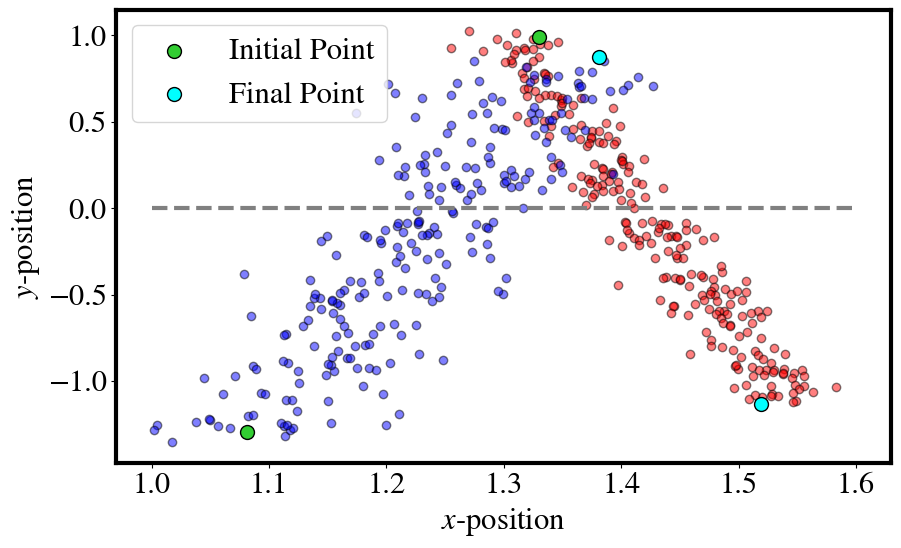

In [225]:
plt.scatter(red_x_pos, red_y_pos, color="red", alpha=0.5, edgecolor="black")
plt.scatter(blue_x_pos, blue_y_pos, color="blue", alpha=0.5, edgecolor="black")

plt.scatter(red_x_pos[0], red_y_pos[0],s=100, color="limegreen", alpha=1, edgecolor="black", label="Initial Point")
plt.scatter(blue_x_pos[0], blue_y_pos[0],s=100, color="limegreen", alpha=1, edgecolor="black")

plt.scatter(red_x_pos[-1], red_y_pos[-1],s=100, color="cyan", alpha=1, edgecolor="black", label="Final Point")
plt.scatter(blue_x_pos[-1], blue_y_pos[-1],s=100, color="cyan", alpha=1, edgecolor="black")

plt.hlines(y=0, xmin=1, xmax=1.6, color="gray", linestyle="--", linewidth=3)
plt.xlabel("$x$-position")
plt.ylabel("$y$-position")
plt.legend()
plt.show()

## Calculate Speeds and Velocities

In [86]:
dt = np.diff(time)
dx_red, dy_red = np.diff(red_x_pos), np.diff(red_y_pos)
dx_blue,dy_blue = np.diff(blue_x_pos), np.diff(blue_y_pos)

#velocities
Vx_red, Vy_red = dx_red/dt, dy_red/dt
Vx_blue, Vy_blue = dx_blue/dt, dy_blue/dt

#speeds
V_red = np.sqrt(Vx_red**2 + Vy_red**2)
V_blue = np.sqrt(Vx_blue**2 + Vy_blue**2)

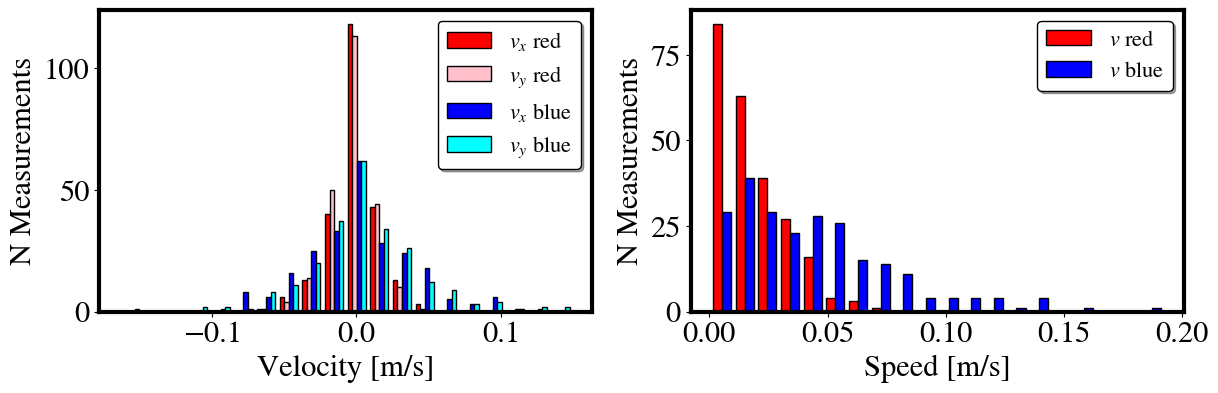

In [173]:
f, axes = plt.subplots(1,2,figsize=(14,4))


axes[0].hist([Vx_red, Vy_red, Vx_blue, Vy_blue], bins=20, color=['red','pink','blue','cyan'],
             edgecolor="black", label=["$v_x$ red", "$v_y$ red","$v_x$ blue","$v_y$ blue"])
axes[0].set_xlabel("Velocity [m/s]")
axes[0].set_ylabel("N Measurements")
axes[0].legend(edgecolor="black", shadow=True, ncol=1, fontsize=16)

axes[1].hist([V_red, V_blue], bins=20, color=['red','blue'], edgecolor="black", label=["$v$ red", "$v$ blue"])
axes[1].set_xlabel("Speed [m/s]")
axes[1].set_ylabel("N Measurements")
axes[1].legend(edgecolor="black", shadow=True, ncol=1, fontsize=16)
plt.show()

## Velocity Posterior

In [224]:
# bounds on prior velocity dist (m/s)
vmin, vmax = -0.2, 0.2

with pymc3.Model() as model_vel:
    mean = pymc3.Uniform('mean', vmin, vmax, shape=4)
    var = pymc3.Uniform("var", 0, 0.05, shape=4)
    
    vx_red = pymc3.Data('vx_red', Vx_red)
    X_vx_red = pymc3.Normal('X_vx_red', mu=mean[0], sigma=np.sqrt(var[0]), observed=vx_red)
    
    vy_red = pymc3.Data('vy_red', Vy_red)
    X_vy_red = pymc3.Normal('X_vy_red', mu=mean[1], sigma=np.sqrt(var[1]), observed=vy_red)
    
    vx_blue = pymc3.Data('vx_blue', Vx_blue)
    X_vx_blue = pymc3.Normal('X_vx_blue', mu=mean[2], sigma=np.sqrt(var[2]), observed=vx_blue)
    
    vy_blue = pymc3.Data('vy_blue', Vy_blue)
    X_vy_blue = pymc3.Normal('X_vy_blue', mu=mean[3], sigma=np.sqrt(var[3]), observed=vy_blue)
  
    

with model_vel:
    step = pymc3.NUTS()
    trace_vel = pymc3.sample(20000, step=[step], cores=4, return_inferencedata=False)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [var, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 51 seconds.


In [159]:
# import arviz as az
# with model:
#     _ = az.plot_trace(trace[1000:][::5])

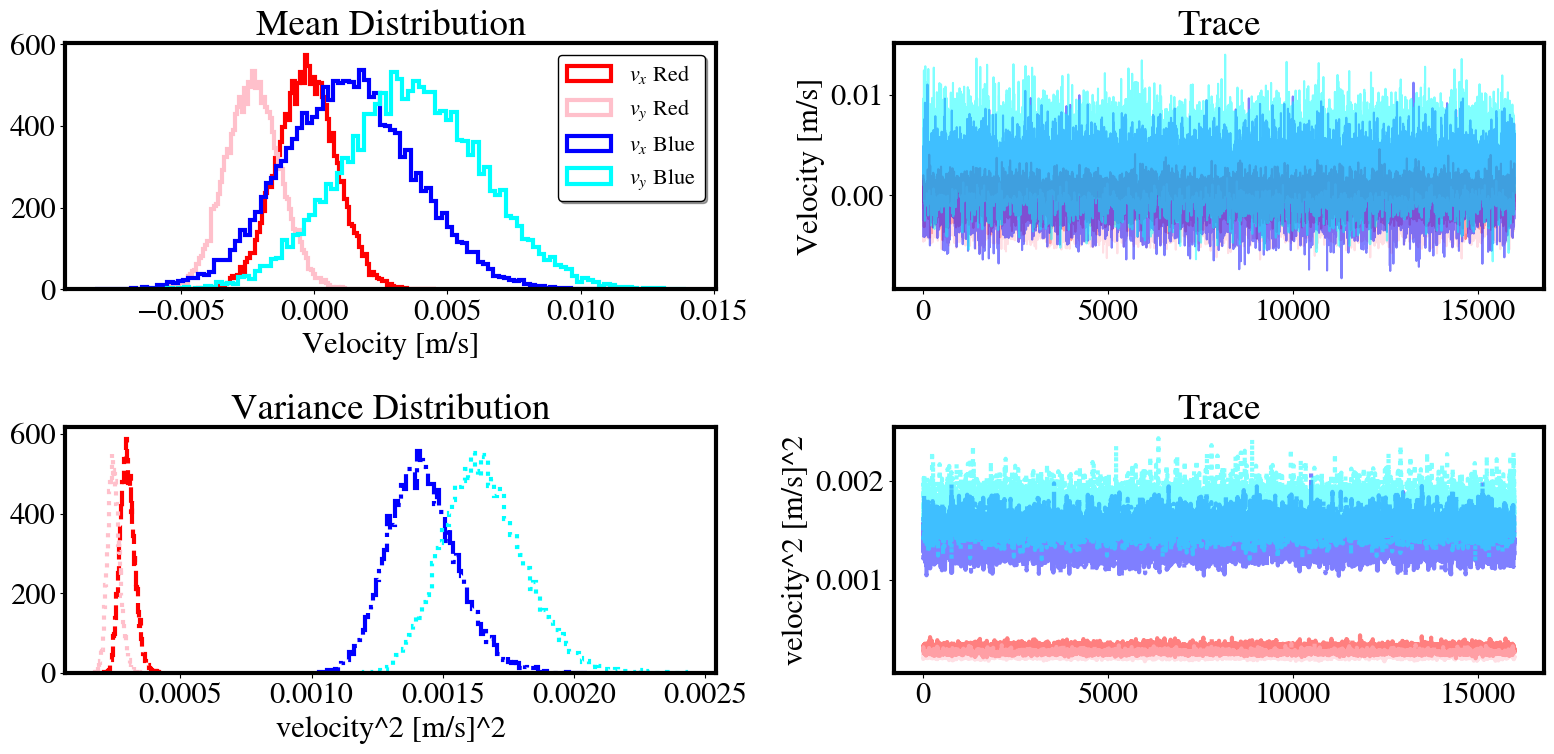

In [227]:

f, axes = plt.subplots(2,2, figsize=(16,8))
axes[0,0].hist(trace_vel.mean[:,0][::5], bins=100, histtype="step", color="red", linewidth=3, label="$v_x$ Red")
axes[0,0].hist(trace_vel.mean[:,1][::5], bins=100, histtype="step", color="pink", linewidth=3, label="$v_y$ Red")
axes[0,0].hist(trace_vel.mean[:,2][::5], bins=100, histtype="step", color="blue", linewidth=3, label="$v_x$ Blue")
axes[0,0].hist(trace_vel.mean[:,3][::5], bins=100, histtype="step", color="cyan", linewidth=3, label="$v_y$ Blue")
axes[0,0].set_xlabel("Velocity [m/s]")
axes[0,0].set_title("Mean Distribution")
axes[0,0].legend(fontsize=16, edgecolor="black", shadow=True)

axes[0,1].plot(trace_vel.mean[:,0][::5],color="red",alpha=0.5, label="$v_x$ Red")
axes[0,1].plot(trace_vel.mean[:,1][::5],color="pink",alpha=0.5,label="$v_y$ Red")
axes[0,1].plot(trace_vel.mean[:,2][::5],color="blue",alpha=0.5,label="$v_x$ Blue")
axes[0,1].plot(trace_vel.mean[:,3][::5],color="cyan",alpha=0.5,label="$v_y$ Blue")
axes[0,1].set_ylabel("Velocity [m/s]")
axes[0,1].set_title("Trace")

axes[1,0].hist(trace_vel.var[:,0][::5],bins=100,histtype="step", color="red", linewidth=3, linestyle="--",label="Red")
axes[1,0].hist(trace_vel.var[:,1][::5],bins=100,histtype="step", color="pink", linewidth=3,linestyle=":", label="Blue")
axes[1,0].hist(trace_vel.var[:,2][::5],bins=100,histtype="step", color="blue", linewidth=3, linestyle="dashdot",label="Red")
axes[1,0].hist(trace_vel.var[:,3][::5],bins=100,histtype="step", color="cyan", linewidth=3,linestyle="dotted", label="Blue")
axes[1,0].set_xlabel("velocity^2 [m/s]^2")
axes[1,0].set_title("Variance Distribution")
# axes[1,0].legend()

axes[1,1].plot(trace_vel.var[:,0][::5], color="red", linewidth=3, alpha=0.5,linestyle="--",label="Red")
axes[1,1].plot(trace_vel.var[:,1][::5], color="pink", linewidth=3, alpha=0.5,linestyle=":", label="Blue")
axes[1,1].plot(trace_vel.var[:,2][::5], color="blue", linewidth=3, alpha=0.5,linestyle="dashdot",label="Red")
axes[1,1].plot(trace_vel.var[:,3][::5], color="cyan", linewidth=3, alpha=0.5,linestyle="dotted", label="Blue")
axes[1,1].set_ylabel("velocity^2 [m/s]^2")
axes[1,1].set_title("Trace")

plt.tight_layout()
plt.show()

In [229]:
μ_red_x = np.mean(trace_vel.mean[:,0])
μ_red_y = np.mean(trace_vel.mean[:,1])
μ_blue_x = np.mean(trace_vel.mean[:,2])
μ_blue_y = np.mean(trace_vel.mean[:,3])

σ_red_x = np.mean(trace_vel.var[:, 0])
σ_red_y = np.mean(trace_vel.var[:, 1])
σ_blue_x = np.mean(trace_vel.var[:, 2])
σ_blue_y = np.mean(trace_vel.var[:, 3])

 
print(f"Red vx Distribution is Gaussian with mean = {μ_red_x:0.5f} m/s and σ = {σ_red_x:0.5f} m/s")
print(f"Red vy Distribution is Gaussian with mean = {μ_red_y:0.5f} m/s and σ = {σ_red_y:0.5f} m/s")
print(f"Blue vx Distribution is Gaussian with mean = {μ_blue_x:0.5f} m/s and σ = {σ_blue_x:0.5f} m/s")
print(f"Blue vy Distribution is Gaussian with mean = {μ_blue_y:0.5f} m/s and σ = {σ_blue_y:0.5f} m/s")

Red vx Distribution is Gaussian with mean = -0.00028 m/s and σ = 0.00030 m/s
Red vy Distribution is Gaussian with mean = -0.00228 m/s and σ = 0.00025 m/s
Blue vx Distribution is Gaussian with mean = 0.00127 m/s and σ = 0.00142 m/s
Blue vy Distribution is Gaussian with mean = 0.00366 m/s and σ = 0.00165 m/s


## a) Speed Posterior

In [230]:
# bounds on prior velocity dist (m/s)
vmin, vmax = 0.0, 0.2

with pymc3.Model() as model_speed:
    mean = pymc3.Uniform('mean', vmin, vmax, shape=2)
    var = pymc3.Uniform("var", 0, 0.05, shape=2)
    
    v_red = pymc3.Data('v_red', V_red)
    X_v_red = pymc3.Normal('X_v_red', mu=mean[0], sigma=np.sqrt(var[0]), observed=v_red)
    
    v_blue = pymc3.Data('v_blue', V_blue)
    X_v_blue = pymc3.Normal('X_v_blue', mu=mean[1], sigma=np.sqrt(var[1]), observed=v_blue)
  
    
with model_speed:
    step = pymc3.NUTS()
    trace_speed = pymc3.sample(20000, step=[step], cores=4, return_inferencedata=False)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [var, mean]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 52 seconds.


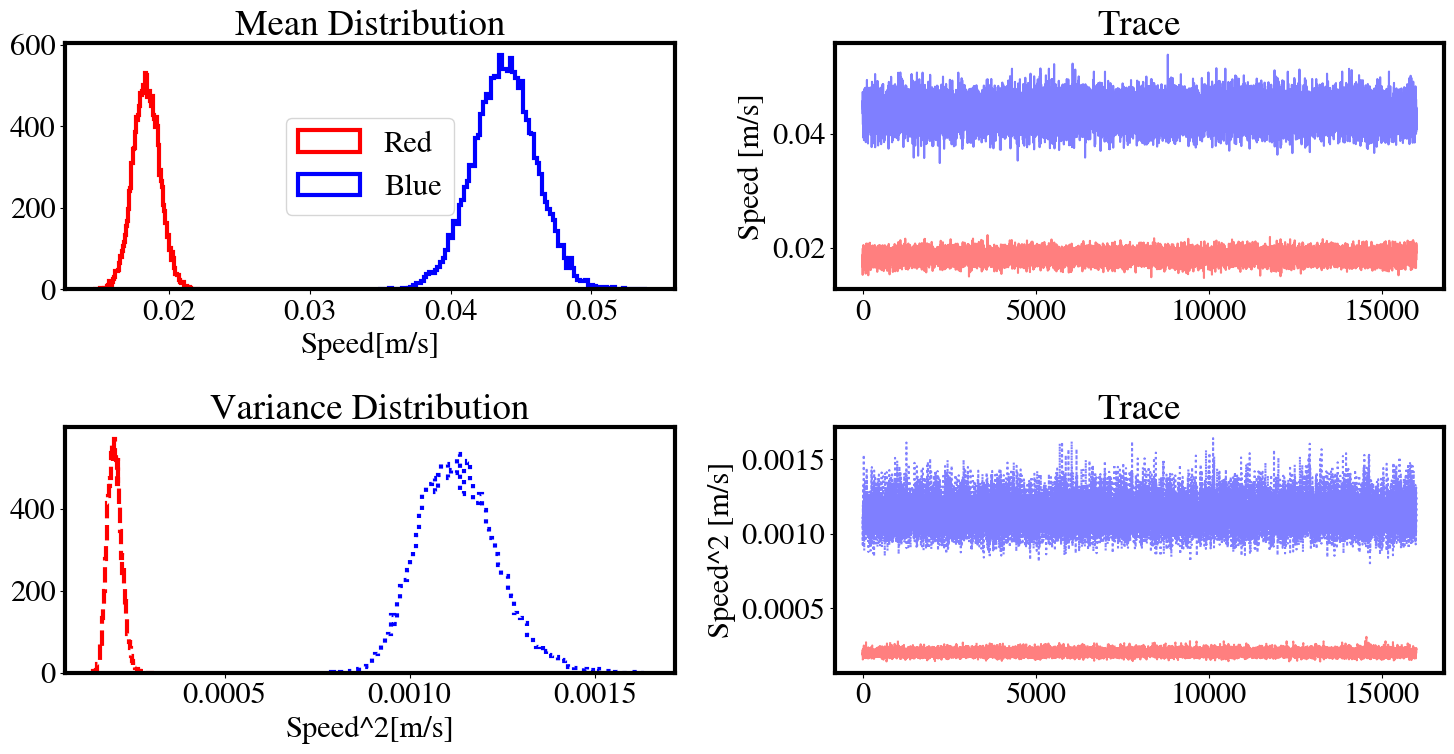

In [231]:
f, axes = plt.subplots(2,2, figsize=(15,8))
axes[0,0].hist(trace_speed.mean[:,0][::5],bins=100,histtype="step", color="red", linewidth=3, label="Red")
axes[0,0].hist(trace_speed.mean[:,1][::5],bins=100,histtype="step", color="blue", linewidth=3, label="Blue")
axes[0,0].set_xlabel("Speed[m/s]")
axes[0,0].set_title("Mean Distribution")
axes[0,0].legend(loc='center')

axes[0,1].plot(trace_speed.mean[:,0][::5],color="red",alpha=0.5, label="$v$ Red")
axes[0,1].plot(trace_speed.mean[:,1][::5],color="blue",alpha=0.5,label="$v$ Blue")
axes[0,1].set_ylabel("Speed [m/s]")
axes[0,1].set_title("Trace")

axes[1,0].hist(trace_speed.var[:,0][::5],bins=100,histtype="step", color="red", linewidth=3, linestyle="--",label="Red")
axes[1,0].hist(trace_speed.var[:,1][::5],bins=100,histtype="step", color="blue", linewidth=3,linestyle=":", label="Blue")
axes[1,0].set_xlabel("Speed^2[m/s]")
axes[1,0].set_title("Variance Distribution")
# axes[1,0].legend()

axes[1,1].plot(trace_speed.var[:,0][::5],color="red",alpha=0.5, linestyle="--",label="$v$ Red")
axes[1,1].plot(trace_speed.var[:,1][::5],color="blue",alpha=0.5,linestyle=":",label="$v$ Blue")
axes[1,1].set_ylabel("Speed^2 [m/s]")
axes[1,1].set_title("Trace")

plt.tight_layout()
plt.show()

In [223]:
μ_red = np.mean(trace_speed.mean[:,0])
μ_blue = np.mean(trace_speed.mean[:,1])

σ_red = np.mean(trace_speed.var[:,0])
σ_blue = np.mean(trace_speed.var[:,1])
 
print(f"Red Speed Distribution is Gaussian with mean = {μ_red:0.5f} m/s and σ = {σ_red:0.5f} m/s")
print(f"Blue Speed Distribution is Gaussian with mean = {μ_blue:0.5f} m/s and σ = {σ_blue:0.5f} m/s")

Red Speed Distribution is Gaussian with mean = 0.01843 m/s and σ = 0.00020 m/s
Blue Speed Distribution is Gaussian with mean = 0.04383 m/s and σ = 0.00113 m/s


## b) Confidence Interval

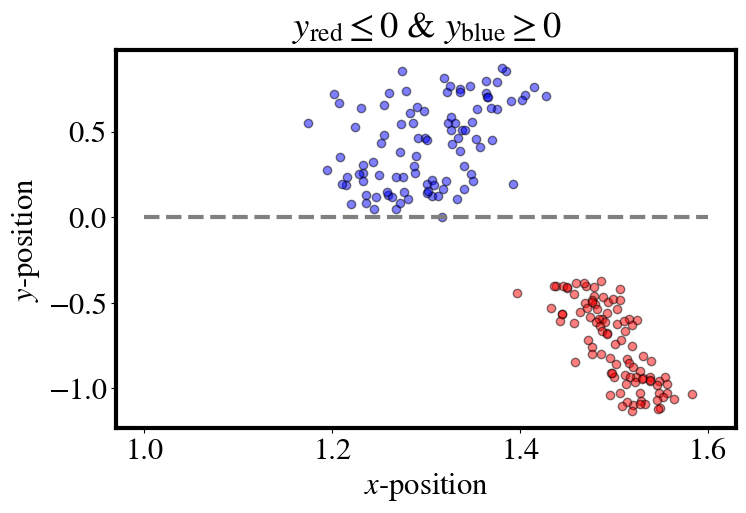

In [150]:

indexes = np.where((red_y_pos <= 0.0) & (blue_y_pos >= 0))

plt.figure(figsize=(8,5))
plt.title("$y_{\mathrm{red}} \leq 0$ & $y_{\mathrm{blue}} \geq 0$", pad=10)
plt.scatter(red_x_pos[indexes], red_y_pos[indexes], color="red", alpha=0.5, edgecolor="black")
plt.scatter(blue_x_pos[indexes], blue_y_pos[indexes], color="blue", alpha=0.5, edgecolor="black")
plt.hlines(y=0, xmin=1, xmax=1.6, color="gray", linestyle="--", linewidth=3)
plt.xlabel("$x$-position")
plt.ylabel("$y$-position")
plt.show()


Now we use the velocity to estimate the time interval

In [236]:

def blue_y(t):
    return t * (np.random.normal(loc=μ_blue_y, scale=σ_blue_y))

def red_y(t):
    return t * (np.random.normal(loc=μ_red_y, scale=σ_red_y))

blue_y(time[indexes])
red_y(time[indexes])

array([-1.37912926, -1.38469954, -1.38730745, -1.39296469, -1.39973093,
       -1.40345288, -1.40662049, -1.41271049, -1.41811841, -1.42180856,
       -1.42718442, -1.43215601, -1.45880309, -1.4626174 , -1.4690637 ,
       -1.47167877, -1.48588102, -1.50248385, -1.5056554 , -1.50872398,
       -1.51319378, -1.51692052, -1.51952421, -1.54933894, -1.55302189,
       -1.55795153, -1.5606382 , -1.56296827, -1.56691715, -1.57023598,
       -1.58743669, -1.58984695, -1.59796448, -1.60146223, -1.60503039,
       -1.61235851, -1.61863639, -1.63325622, -1.63770802, -1.64176792,
       -1.64720057, -1.65153472, -1.65583878, -1.66098018, -1.66503208,
       -1.66865883, -1.67210229, -1.72161929, -1.7253768 , -1.77916275,
       -1.78473467, -1.79046516, -1.79307462, -1.79796209, -1.83820615,
       -1.8417146 , -1.84956882, -1.8536956 , -1.85691479, -1.86095808,
       -1.87885698, -1.90686345, -1.91727809, -1.92080652, -1.92451865,
       -1.9305064 , -1.93384834, -1.9373157 , -1.95031498, -1.95

## c) & d)

I have no idea what how to do what is being asked.... This PSET was really confusing and I don't have enough time to finish :(